Suppose you have some vectors and wish to find, for each point, the $k$ nearest points. While you could compute pairwise distances using a naïve quadratic algorithm for small datasets, this approach becomes infeasible with millions or billions of points. If the points are in a low-dimensional space, clever data structures like [kd-trees](https://en.wikipedia.org/wiki/K-d_tree), ball trees, and M-trees can achieve substantial speedups. However, in high dimensions, performance degrades, and you may need to sacrifice exactness and turn to Approximate Nearest Neighbors ([ANN](https://en.wikipedia.org/wiki/Nearest_neighbor_search#Approximation_methods)) techniques.

Locality-sensitive hashing ([LSH](https://en.wikipedia.org/wiki/Locality-sensitive_hashing)) is a family of ANN algorithms that aim to group similar points into the same (or nearby) buckets efficiently using specialized hash functions. Recall that traditional hashing tries to map items to a set of buckets uniformly and minimize collisions. Thus, traditionally, slightly changing a point results in a vastly different hash and assigned bucket. LSH uses different hashing functions that often depend on the distance metric employed. Here, we explore a simple approach using cosine distance based on [Random Projection](https://en.wikipedia.org/wiki/Random_projection).

### How it works
The mechanics are not very complicated. We first generate $N_h$ random hyperplanes. Let's visualize this in two dimensions with $n=5$ points and $N_h=2$:

In [47]:
#| code-summary: Imports
#| output: false
#| echo: false
import torch
import matplotlib.pyplot as plt
torch.manual_seed(42)

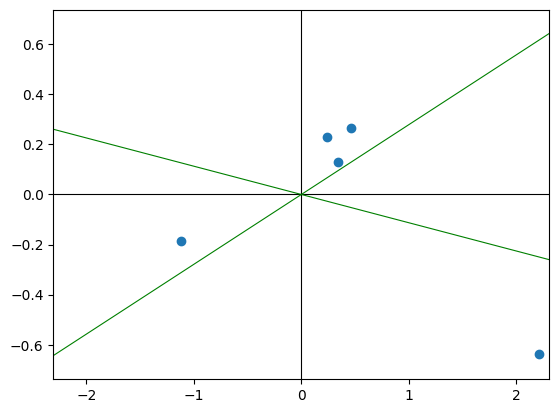

In [48]:
#| code-summary: Random data and visualisation

# Note that we sample from a standard normal distribution
X = torch.randn((5, 2))
rand_planes = torch.randn((2, 2)) - 0.5

def lims(X, ax, eps = 0.1):
    m = X[:, ax].abs().max().item()
    m += eps
    return (-m, m)

plt.scatter(X[:, 0], X[:, 1])
plt.xlim(lims(X, 0)); plt.ylim(lims(X, 1))

# Axes
plt.axline((0,0), (0,1), c = '0', linewidth = 0.8)
plt.axline((0,0), (1,0), c = '0', linewidth = 0.8)

# Random planes
for v in rand_planes:
    x, y = v.tolist()
    plt.axline((0,0), (y, -x), c = 'g', linewidth = 0.8)

Note that the plane is effectively partitioned into four regions. The main idea is to treat the regions as buckets and assign all the points in a region to the same bucket. When a new point comes along, we simply find out which region it belongs to and then search for points in that region and nearby regions until we accumulate $k$ of them.

Great! How do we do it computationally? We mainly need to remember that a hyperplane is characterized by its normal vector $\vec{v}$ and that we can determine on which side of it a point $x$ lies by the sign of their dot product, $\text{sign}(\vec{v} \cdot \vec{x})$. For example, points 0 and 2 are on opposite sides of hyperplane 0:

In [49]:
#| code-fold: false
v = rand_planes[0]
v @ X[0] >= 0, v @ X[2] >= 0

(tensor(True), tensor(False))

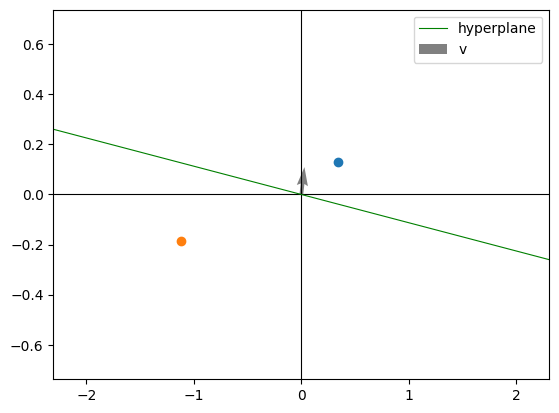

In [50]:
#| code-summary: Dot product example
plt.scatter(*X[0].tolist())
plt.scatter(*X[2].tolist())
plt.xlim(lims(X, 0)); plt.ylim(lims(X, 1))
plt.axline((0,0), (0,1), c = '0', linewidth = 0.8)
plt.axline((0,0), (1,0), c = '0', linewidth = 0.8)

x, y = rand_planes[0].tolist()
plt.axline((0,0), (y, -x), c = 'g', linewidth = 0.8, label = 'hyperplane')
plt.quiver(*([0], [0]), x, y, color = '0.5', label = 'v')
plt.legend()

Thus, to find a point's region, we can repeat this process for all (in our case, two) of the hyperplanes. For example:

In [51]:
#| code-fold: false
X[0] @ rand_planes[0] >= 0, X[0] @ rand_planes[1] >= 0

(tensor(True), tensor(False))

In [52]:
#| code-fold: false
X[2] @ rand_planes[0] >= 0, X[2] @ rand_planes[1] >= 0

(tensor(False), tensor(False))

I.e., points 0 and 2 are in different regions. Using matrix notation, we can obtain every point's region succinctly:

In [53]:
#| code-fold: false
regions = X @ rand_planes.T >= 0
regions

tensor([[ True, False],
        [ True, False],
        [False, False],
        [False,  True],
        [ True, False]])

We can now place each point in a region into a bucket:

In [54]:
#| code-fold: false
buckets = {}
for i, reg in enumerate(regions):
    reg = tuple(reg.tolist())
    if reg not in buckets: buckets[reg] = []
    buckets[reg].append(i)
buckets

{(True, False): [0, 1, 4], (False, False): [2], (False, True): [3]}

And that's all the preprocessing we need to do. Now, to find the nearest neighbors of a query point $\vec{q}$, we find its region:

In [55]:
#| code-fold: false
q = torch.randn((2,))
q_reg = tuple((q @ rand_planes.T >= 0).tolist())
q, q_reg, buckets.get(q_reg, [])

(tensor([-0.9890,  0.9580]), (True, False), [0, 1, 4])

In this case, we had three points in the query's bucket. When the number of elements in the bucket is less than $k$, the common approach is to look to nearby buckets in terms of Hamming distance. I.e., we first add points in buckets one bit flip away, then two flips away, and so on until we accumulate $k$ (or slightly more) points.

### Considerations

To help root out any false positives—points that are not in the top $k$ nearest but happened to land in or near the buckets—we can calculate the actual cosine distance from the candidate points we retrieved and return only those below a specified threshold.

You can imagine that the number of hyperplanes presents an accuracy-speed tradeoff: more hyperplanes imply (exponentially) more buckets, which means fewer false positives but also more computation to calculate regions. You can find details in the references.

If you get unlucky with the random generation of the hyperplanes, you might have a high false negative rate—actually close points that end up in far-away buckets. In this case, we could generate other sets of hyperplanes, obtain their respective candidates, and obtain a candidate pool by taking their union. See the [LSH Forest paper](http://infolab.stanford.edu/~bawa/Pub/similarity.pdf).

As a final note, how we generate hyperplanes is somewhat important. You can imagine that we generally want them to be evenly distributed on the unit sphere, which is why we sample from a normal distribution. We'd also like them to be spaced out, which is why some methods generate (expensive) orthogonal random matrices. Or you might not care in practice, remembering that in high dimensions, [pairs of sampled points are almost surely orthogonal](https://math.stackexchange.com/questions/995623/why-are-randomly-drawn-vectors-nearly-perpendicular-in-high-dimensions).

### Resources

- [Blog post w/some probabilty details](https://towardsdatascience.com/similarity-search-part-6-random-projections-with-lsh-forest-f2e9b31dcc47)
- [Mining of Massive Datasets](http://www.mmds.org/) (book and course, chapter 3)
- [Similarity Estimation Techniques from Rounding
Algorithms](https://www.cs.princeton.edu/courses/archive/spr04/cos598B/bib/CharikarEstim.pdf)